In [1]:

import torch
import matplotlib.pyplot as plt
from umap import UMAP
import numpy as np

# Load the data
mappers = {
    'action_group' : np.load('text_backup/action_group_mapper.npy', allow_pickle=True).item(),
    'action' : np.load('text_backup/action_mapped_2_mapper.npy', allow_pickle=True).item(),
}

V = '128'
path_base = f'logs/MotionVAE/VAE1/train/version_{V}/saved_latent/'

# action_groups = torch.load(path_base + 'action_group_test.pt')
# actions = torch.load(path_base + 'action_test.pt')
# latent = torch.load(path_base + 'latent_test.pt')

actions_groups = torch.cat([torch.load(path_base + 'action_group_test.pt'), 
                            torch.load(path_base + 'action_group_val.pt')], dim=0)
actions = torch.cat([torch.load(path_base + 'action_test.pt'),
                        torch.load(path_base + 'action_val.pt')], dim=0)
latent = torch.cat([torch.load(path_base + 'latent_test.pt'),
                        torch.load(path_base + 'latent_val.pt')], dim=0)

In [2]:
print(actions_groups.shape, actions.shape, latent.shape)    

torch.Size([5830]) torch.Size([5830]) torch.Size([5830, 1024])


In [3]:
# scale first

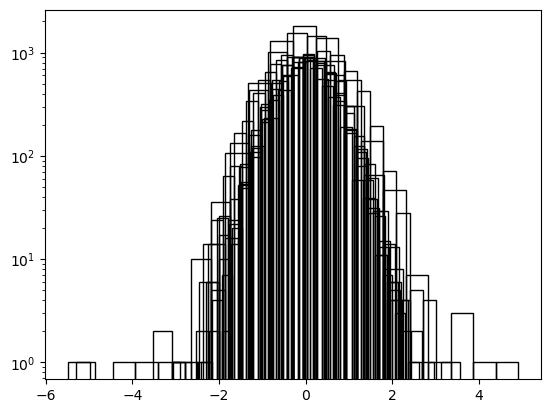

In [4]:
for i in range(10):
    plt.hist(latent[:,i], fill=False, bins=20)
plt.yscale('log')

In [5]:
# what are some otherr ways we can scale this data?
# 1. StardardScaler
# 2. MinMaxScaler
# 3. RobustScaler
# 4. Normalizer
# 5. QuantileTransformer
# 6. PowerTransformer
# 7. MaxAbsScaler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer, MaxAbsScaler

scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer(), QuantileTransformer(), PowerTransformer(), MaxAbsScaler()]



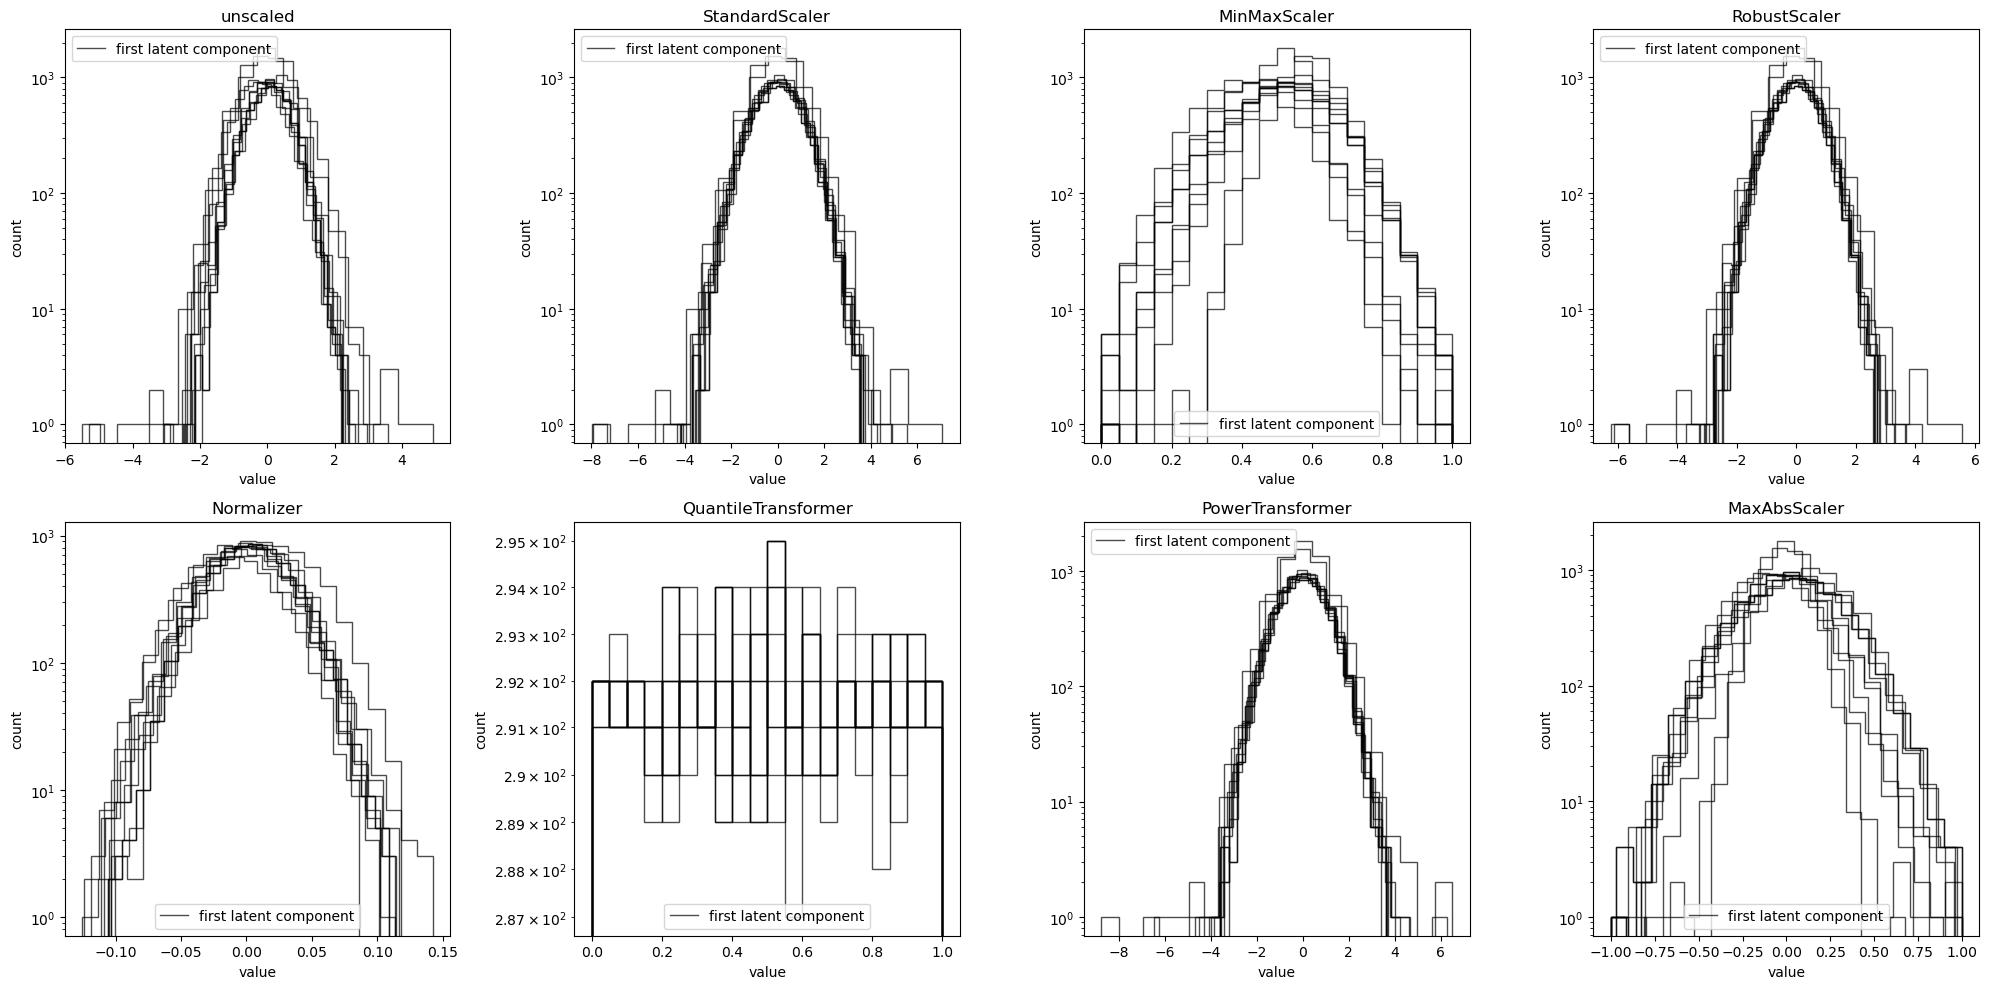

In [6]:
# scaling the latent space
def plot_latent_component_distributions(latent, scaler, ax, max_samples=10):
    latent = latent.detach().cpu().numpy().copy()
    if scaler is not None:
        latent = scaler.fit_transform(latent)
    latent_s = latent
    for i in range(min(latent_s.shape[1], max_samples)):
        n, bins = np.histogram(latent_s[:,i], bins=20)
        if i == 0:
            ax.stairs(n, bins, fill=False, lw=1, alpha=0.7, color='black', label='first latent component')
        ax.stairs(n, bins, fill=False, lw=1, alpha=0.7, color='black')
    ax.legend()
    ax.set_title(scaler.__class__.__name__ if scaler is not None else 'unscaled')
    ax.set_ylabel('count')
    ax.set_xlabel('value')
    ax.set_yscale('log')
    return latent_s

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for ax, scaler in zip(axs.flatten(), scalers):
    latent_s = plot_latent_component_distributions(latent, scaler, ax)
plt.tight_layout()

save_path = '../app/assets_produced/17_Motion_VAE_final/'
plt.savefig(save_path + f'latent_distributions_with_various_scalers_{V}.png')


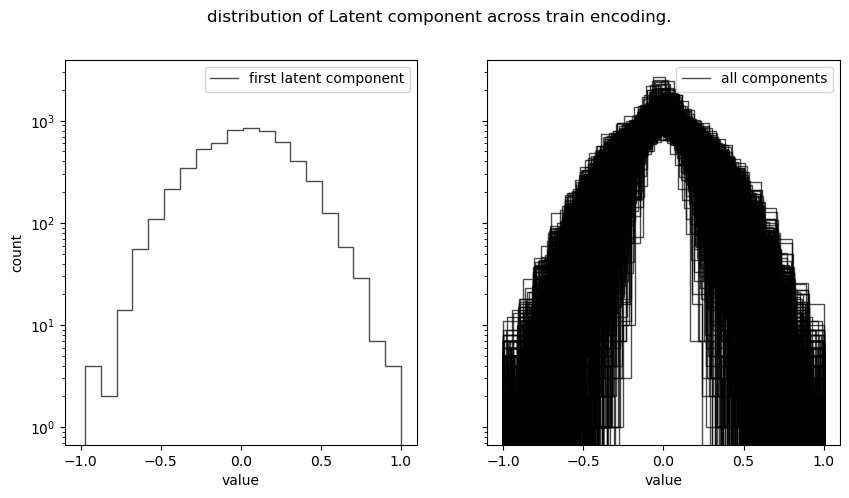

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
for i in range(latent.shape[1]):
    # use numpy histogram to get the bin edges
    n, bins = np.histogram(latent_s[:,i], bins=20)
    if i == 0:
        ax[0].stairs(n, bins, fill=False, lw=1, alpha=0.7, color='black', label='first latent component')
        ax[1].stairs(n, bins, fill=False, lw=1, alpha=0.7, color='black', label='all components')

    ax[1].stairs(n, bins, fill=False, lw=1, alpha=0.7, color='black')
    # ax[0].hist(latent_s[:,i], fill=False, bins=20, alpha=0.7, lw=.5)


# ax[0].hist(latent_s[:,0], fill=False, bins=20, alpha=0.7, lw=2, label='latent component 0', edgecolor='red')
# plt.hist(latent_s[:,1], fill=False, bins=20, alpha=0.7, lw=2, label='latent component 1', edgecolor='orange')
ax[0].legend()
ax[1].legend()
# ax[0].set_title('')
ax[0].set_ylabel('count')
ax[0].set_xlabel('value')
ax[1].set_xlabel('value')
plt.yscale('log')
fig.suptitle('distribution of Latent component across train encoding.')

caption = """
Distribution of vector components in the latent space. This is even the normal scaled latent space.

The problem here is that we see some very high values in the latent space.

This is a problem because it is too distant from the noise we will add in the diffusion process.

So we need to increase the KL weight in the loss function to make the latent space more compact.
"""


plt.savefig(save_path + f'latent_component_distribution_{V}.png', dpi=300)

In [8]:
# I dont know if the above makes it clear, we cant just scale it, bevause it already is so close to normal
# ahh yes! The above is already scaled, so we need to scale it even more, so that the values are closer to 0
# 0.000_0001 -> 0.000_001
# So we will increase the KL weight by an order of magnitude, and see if that helps: $10^{-6} -> 10^{-5}$





In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(latent)

pca.explained_variance_ratio_

array([0.04882727, 0.04175634, 0.0339636 , 0.03349582, 0.02808741])

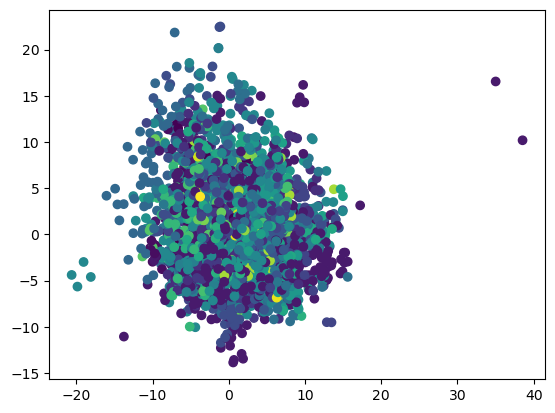

In [10]:
z = pca.transform(latent)
plt.scatter(z[:, 0], z[:, 1], c=actions_groups.numpy())

In [11]:
# Project to 2D
umap = UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
latent_2d = umap.fit_transform(latent)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecate

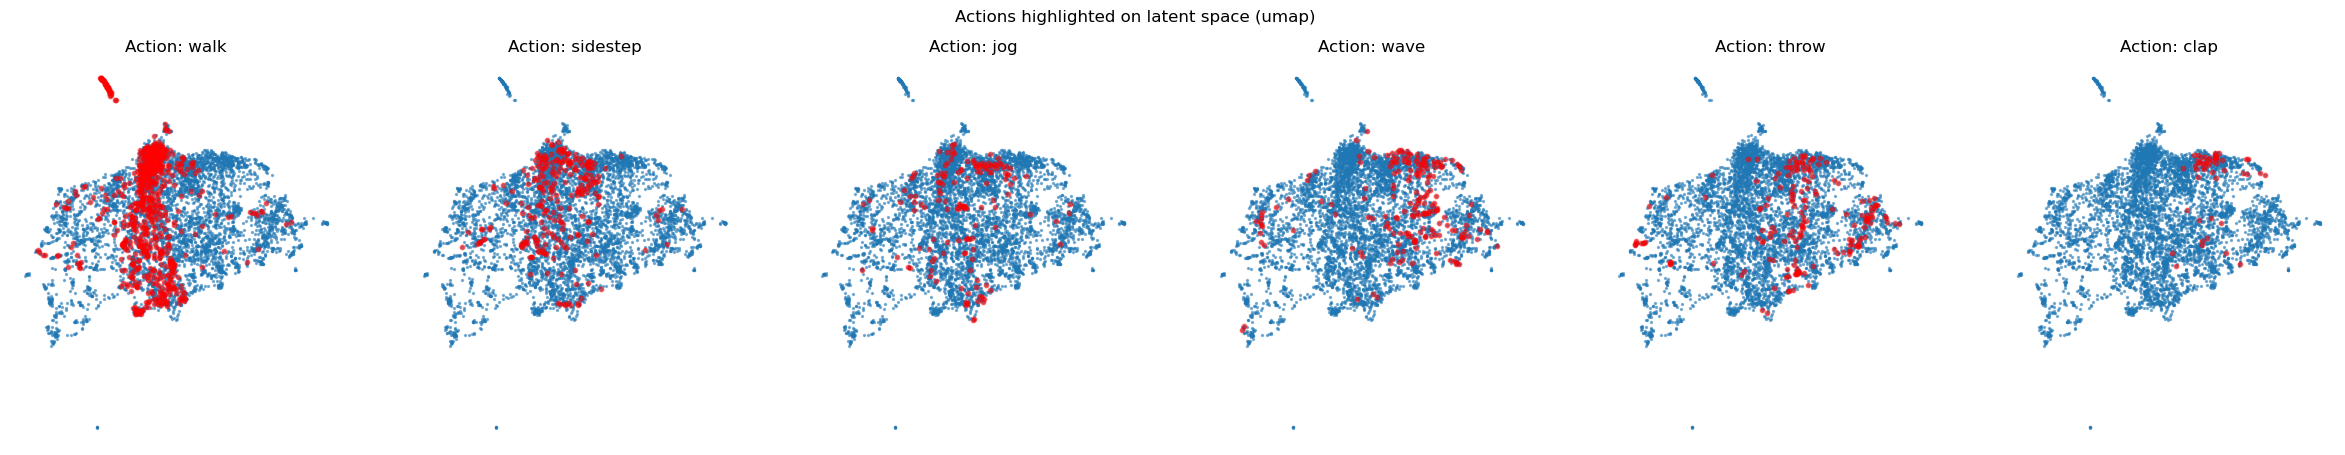

In [12]:
actions_to_show = ["walk", 'sidestep', 'jog', 'wave', 'throw', 'clap']
# actions_to_show = "walk, jump, sidestep, wave, lift, throw, jog, turn, stretch, sit, raise, step, kick, circle, gesture, swing, dance, stumble, spin, climb, punch, run, stand, balance".split(', ')
fig, axes = plt.subplots(1, len(actions_to_show), figsize=(5 * len(actions_to_show), 5))
actions_mapped = [mappers['action'][a.item()] for a in actions]
for action, ax in zip(actions_to_show, axes):
    
    # idx where action is jump
    idx_action = [i for i, a in enumerate(actions_mapped) if a == action]

    ax.scatter(latent_2d[:, 0], 
                latent_2d[:, 1], 
                # c=actions,
                alpha=0.5,
                s=2
                #cmap='tab30'
                )

    ax.scatter(latent_2d[idx_action, 0],
                latent_2d[idx_action, 1],
                c='red',
                alpha=0.5,
                s=10
                )
    ax.set_title(f'Action: {action}')
    ax.axis('off')

    fig.suptitle(f'Actions highlighted on latent space (umap)')

Text(0.5, 0.98, 'Action Groups highlighted on latent space (umap)')

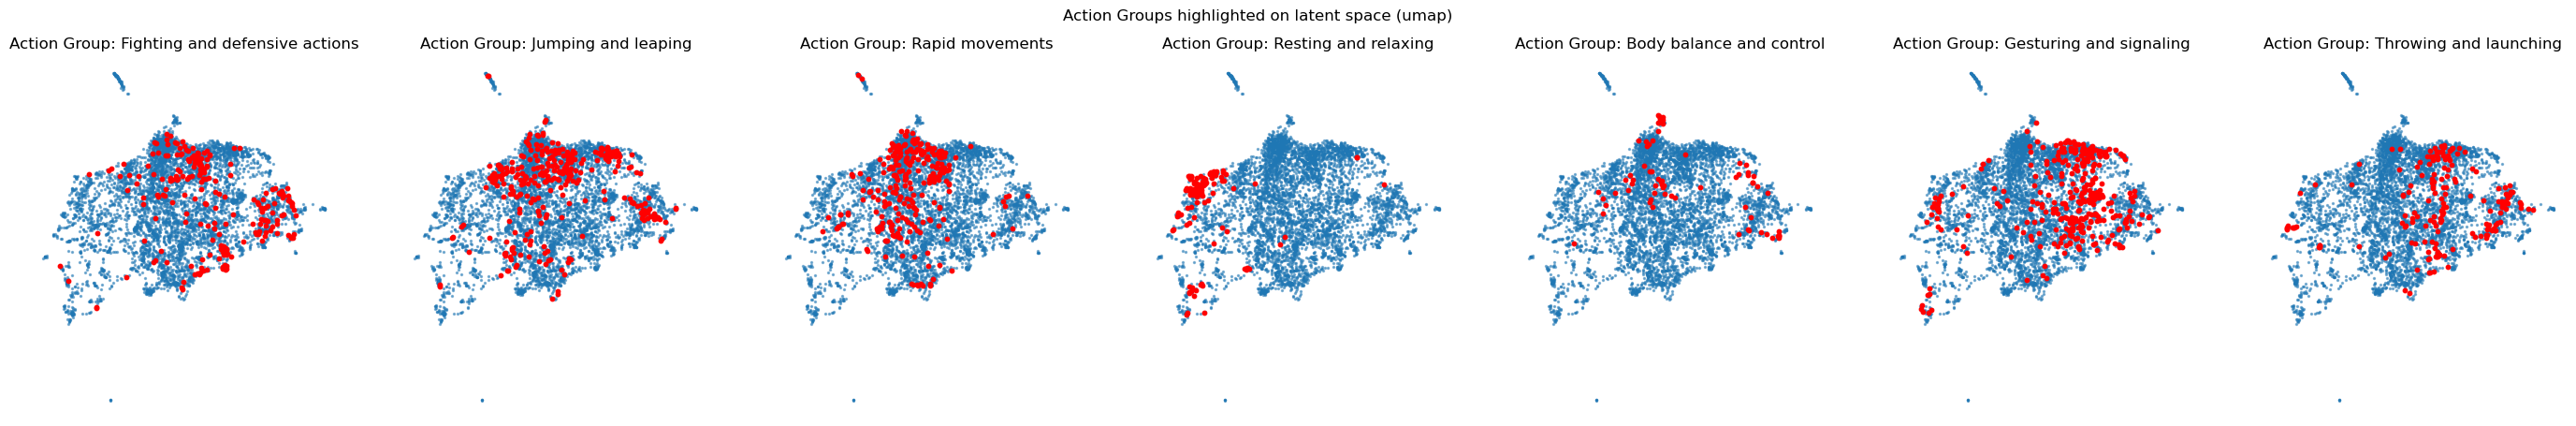

In [13]:
action_groups_to_show = ["Fighting and defensive actions", 
                         "Jumping and leaping", 'Rapid movements', 
                         #'Dancing and rhythmic movements',
                           'Resting and relaxing',
                           'Body balance and control', 
                           'Gesturing and signaling', 
                            'Throwing and launching', 
                            #'Basic locomotion',
                            #'Hand movements'
                            ]
# action_groups_to_show = set(action_group_mapped)
fig, axes = plt.subplots(1, len(action_groups_to_show), figsize=(5 * len(action_groups_to_show), 5)) 

action_group_mapped = [mappers['action_group'][a.item()] for a in actions_groups]
for action_group, ax in zip(action_groups_to_show, axes):
    idx_group = [i for i, a in enumerate(action_group_mapped) if a == action_group]

    ax.scatter(latent_2d[:, 0],
                latent_2d[:, 1],
                # c=action_groups,
                alpha=0.5,
                s=2
                #cmap='tab30'
                )

    ax.scatter(latent_2d[idx_group, 0],
                latent_2d[idx_group, 1],
                c='red',
                s=10
                )
    ax.set_title(f'Action Group: {action_group}')
    ax.axis('off')

fig.suptitle(f'Action Groups highlighted on latent space (umap)')

